In [1]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from functools import reduce  
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from mlxtend.evaluate import bias_variance_decomp
from sklearn import metrics

In [2]:
p = 7
n = 1000
min_cor = 0
max_cor = 0

true_betas = np.array(np.repeat(5, p))
true_betas

array([5, 5, 5, 5, 5, 5, 5])

In [3]:
def get_sim_data(p, n, min_cor, max_cor, true_betas):
    
    sd_vec = np.ones(p) 
    mean = np.zeros(p)
    cor_matrix = np.zeros((p,p))

    correlation = np.random.uniform(min_cor, max_cor, int(p * (p - 1) / 2))
    cor_matrix[np.triu_indices(p, 1)] = correlation
    cor_matrix[np.tril_indices(p, -1)] = cor_matrix.T[np.tril_indices(p, -1)]
    np.fill_diagonal(cor_matrix, 1)


    D = np.diag(sd_vec)
    sigma = D.dot(cor_matrix).dot(D)

    X = np.random.multivariate_normal(mean, sigma, n)
    eps = np.random.normal(0, 1, n)
    
    y_true = X.dot(true_betas)
    y_true = pd.Series(y_true, name = 'y_true')

    y_noise = y_true + eps 
    y_noise = pd.Series(y_noise, name = 'y_noise')
    
    column_names = []
    
    for value in range(1, p + 1): 
        
        column = f"X_{value}"
        column_names.append(column)
        
    
    X = pd.DataFrame(X, columns = column_names)
    
    df = pd.concat([y_noise, X], axis = 1)
    
    return y_true, y_noise, X, df



In [4]:
y_true, y_noise, X, df = get_sim_data(p, n, min_cor, max_cor, true_betas)


In [5]:
"""Zero multicollinearity.
   n = 30; p = 2, 28, 30, 35. 
"""
np.random.seed(123)

n_sim = 30
p_sim = np.array([2, 28, 30, 35])

min_corr_sim = 0
max_corr_sim = 0 
iterations_sim = 1000

matrix_betas_final = []
matrix_betas_mean = []
matrix_bias_sq = []
matrix_betas_var_mean = []
matrix_betas_var_final = []


    
for p in p_sim: 
    
    matrix_var = []
    matrix_betas = []
    
    for i in range(iterations_sim):
    
        true_betas_sim = np.repeat(5, p)
    
        y_true, y_noise, X, df = get_sim_data(p, n_sim, min_corr_sim, max_corr_sim, true_betas_sim) 

        var_cov = np.linalg.inv(np.dot(X.T, X))
        var_betas = var_cov.diagonal() 
        
        #reg = LinearRegression().fit(X, y)
        betas = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_noise)
        
        #matrix_betas.append(reg.coef_)
        matrix_betas.append(betas)
        
        matrix_var.append(var_betas)
        
        X_names = []
        beta_names = []
    
        for value in range(1, p + 1): 
            
            column_X = f"X_{value}"
            column_betas = f"beta_{value}"
            X_names.append(column_X)
            beta_names.append(column_betas)
        
        df_var = pd.DataFrame(matrix_var, columns = X_names)
        df_betas = pd.DataFrame(matrix_betas, columns = beta_names) 
        
        #bias_squared = (df_betas.mean() - true_betas_sim)**2
        
    matrix_betas_final.append(df_betas)
    matrix_betas_mean.append(df_betas.mean())
    #matrix_bias_sq.append(bias_squared)
    matrix_betas_var_mean.append(df_var.mean())
    matrix_betas_var_final.append(df_var)
    
 

In [6]:
#matrix_betas_var_mean[1]
#matrix_betas_mean[0]
#matrix_betas_var_mean[2]
#matrix_betas_var_mean[3]
#matrix_betas_var_mean[4]
#matrix_betas_var_mean[5]
#matrix_betas_var_final
#len(matrix_betas_final)
matrix_betas_final


[       beta_1    beta_2
 0    5.194390  4.814442
 1    4.955953  5.106284
 2    4.915828  4.819898
 3    4.958054  4.814023
 4    5.196928  5.342399
 ..        ...       ...
 995  5.344032  4.789137
 996  5.120733  5.102066
 997  5.031395  4.879691
 998  5.136747  5.185013
 999  4.822832  4.781346
 
 [1000 rows x 2 columns],
        beta_1    beta_2    beta_3    beta_4    beta_5    beta_6    beta_7  \
 0    4.625958  5.709232  5.578969  6.786126  3.711638  5.771189  4.150237   
 1    6.275114  6.594062  4.458962  4.185813  5.622896  5.061225  6.401124   
 2    4.346290  4.313042  3.491141  4.206173  5.769389  5.280490  5.344267   
 3    5.079610  5.361217  4.746899  5.221811  5.298139  5.713871  5.014280   
 4    5.278163  5.168689  4.397753  5.175896  4.277409  5.030779  5.594457   
 ..        ...       ...       ...       ...       ...       ...       ...   
 995  5.161355  4.563418  4.251050  4.384264  4.870468  5.038473  5.309125   
 996  4.861911  3.079180  4.699782  4.351605  7.

In [7]:
#list(enumerate(matrix_betas_final))
matrix_betas_final[0]

,beta_1,beta_2
0,5.194390,4.814442
1,4.955953,5.106284
2,4.915828,4.819898
3,4.958054,4.814023
4,5.196928,5.342399
...,...,...
995,5.344032,4.789137
996,5.120733,5.102066
997,5.031395,4.879691
998,5.136747,5.185013


In [8]:
def iterate_ridge(n, p, min_cor, max_cor, iterations_sim, true_betas, alphas):
    
    beta_var_names = []
    ridge_beta_names = []
    
    for value in range(1, p + 1): 
    
        column_betas_var = f"beta_var_{value}"
        column_betas = f"beta_{value}"
        beta_var_names.append(column_betas_var)
        ridge_beta_names.append(column_betas)

    df_list_betas_ridge = []
    df_list_var_ridge = []

    for i in range(iterations_sim):
        
        true_betas_sim = true_betas
    
        y_true, y_noise, X, df = get_sim_data(p, n, min_cor, max_cor, true_betas_sim) 
        
        i, k = X.shape
        I = np.identity(k)
    
        matr_var = []
        matr_beta = []
    

        for a in alphas: 
        
            ridge_beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + a * I), X.T), y_noise)
            matr_beta.append(ridge_beta)
            df_ridge_betas = pd.DataFrame(matr_beta, columns = ridge_beta_names)
        
            ridge_var_cov = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + a * I), np.dot(X.T, X)), np.linalg.inv(np.dot(X.T, X) + a * I))
            ridge_var = ridge_var_cov.diagonal()
            matr_var.append(ridge_var)
            df_ridge_var = pd.DataFrame(matr_var, columns = beta_var_names)
        
         
        df_list_betas_ridge.append(df_ridge_betas)
        df_list_var_ridge.append(df_ridge_var)
        
    return df_list_betas_ridge, df_list_var_ridge



In [9]:
n_alphas = 100
alphas_1 = np.logspace(-20, 4, n_alphas)
alphas_1

alphas_2 = np.logspace(-6, 4, n_alphas)
alphas_2


alphas_3 = np.logspace(-11, 4, n_alphas)
alphas_3

array([1.00000000e-11, 1.41747416e-11, 2.00923300e-11, 2.84803587e-11,
       4.03701726e-11, 5.72236766e-11, 8.11130831e-11, 1.14975700e-10,
       1.62975083e-10, 2.31012970e-10, 3.27454916e-10, 4.64158883e-10,
       6.57933225e-10, 9.32603347e-10, 1.32194115e-09, 1.87381742e-09,
       2.65608778e-09, 3.76493581e-09, 5.33669923e-09, 7.56463328e-09,
       1.07226722e-08, 1.51991108e-08, 2.15443469e-08, 3.05385551e-08,
       4.32876128e-08, 6.13590727e-08, 8.69749003e-08, 1.23284674e-07,
       1.74752840e-07, 2.47707636e-07, 3.51119173e-07, 4.97702356e-07,
       7.05480231e-07, 1.00000000e-06, 1.41747416e-06, 2.00923300e-06,
       2.84803587e-06, 4.03701726e-06, 5.72236766e-06, 8.11130831e-06,
       1.14975700e-05, 1.62975083e-05, 2.31012970e-05, 3.27454916e-05,
       4.64158883e-05, 6.57933225e-05, 9.32603347e-05, 1.32194115e-04,
       1.87381742e-04, 2.65608778e-04, 3.76493581e-04, 5.33669923e-04,
       7.56463328e-04, 1.07226722e-03, 1.51991108e-03, 2.15443469e-03,
      

In [10]:
np.random.seed(20)

p_regressors = [2, 28, 30, 35]
n = 30
#true_betas = np.repeat(5, p)
min_cor = 0 
max_cor = 0 
iterations = 1

#alphas_1 = np.array([int(0), 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 5, 10, 15, 20, 30, 50, 100, 120, 150, 160, 200, 210, 300, 500, 1000, 10000])
#alphas_2 = np.array([int(0), 0.000000000000001, 0.00000000000001, 0.0000000000001, 0.000000000001])

alphas = [alphas_1, alphas_1, alphas_2, alphas_3]


collect_ridge_betas = []
collect_ridge_var = []

for p, a in zip(p_regressors, alphas): 
    
    ridge_betas, beta_var = iterate_ridge(n, p, min_cor, max_cor, iterations, np.repeat(5, p), a)
    collect_ridge_betas.append(ridge_betas)
    collect_ridge_var.append(beta_var)
    
    


In [11]:
#len(collect_ridge_betas)

list(enumerate(collect_ridge_betas))

regularization_type = "Ridge"

collect_ridge_betas[2][0]

,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,...,beta_21,beta_22,beta_23,beta_24,beta_25,beta_26,beta_27,beta_28,beta_29,beta_30
0,17.308033,8.635381,5.385189,7.059777,-0.705541,10.840145,2.429790,17.622269,-3.383881,28.634703,...,9.324181,8.097149,-6.203056,-13.572841,4.142869,-18.096052,14.094014,-0.730790,-15.015997,-12.283221
1,17.299781,8.633143,5.385302,7.057867,-0.702128,10.836661,2.431514,17.614612,-3.378424,28.618173,...,9.321425,8.094687,-6.195123,-13.560346,4.143992,-18.080775,14.088153,-0.726803,-15.003400,-12.272502
2,17.289385,8.630325,5.385443,7.055461,-0.697828,10.832271,2.433686,17.604965,-3.371549,28.597350,...,9.317952,8.091586,-6.185131,-13.544604,4.145407,-18.061529,14.080770,-0.721781,-14.987531,-12.259000
3,17.276294,8.626776,5.385621,7.052431,-0.692413,10.826743,2.436420,17.592817,-3.362892,28.571129,...,9.313580,8.087681,-6.172547,-13.524783,4.147188,-18.037295,14.071474,-0.715457,-14.967548,-12.241997
4,17.259819,8.622310,5.385845,7.048617,-0.685598,10.819786,2.439862,17.577529,-3.351997,28.538129,...,9.308077,8.082767,-6.156711,-13.499837,4.149429,-18.006795,14.059774,-0.707498,-14.942399,-12.220599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.070572,-0.026424,0.010339,-0.034045,0.057389,0.018168,0.044918,0.053945,0.062603,0.059894,...,0.073639,0.005841,0.023011,0.040914,0.039200,-0.036406,0.081205,0.077278,0.027412,0.026004
96,0.056119,-0.021046,0.008174,-0.027195,0.045612,0.014499,0.035761,0.042906,0.049729,0.047577,...,0.058617,0.004596,0.018284,0.032520,0.031153,-0.029006,0.064483,0.061478,0.021817,0.020679
97,0.044595,-0.016745,0.006465,-0.021687,0.036231,0.011555,0.028443,0.034101,0.039483,0.037775,...,0.046617,0.003621,0.014521,0.025832,0.024744,-0.023086,0.051184,0.048870,0.017349,0.016433
98,0.035418,-0.013312,0.005115,-0.017273,0.028765,0.009198,0.022607,0.027087,0.031336,0.029981,...,0.037047,0.002857,0.011527,0.020510,0.019644,-0.018357,0.040614,0.038823,0.013786,0.013051


In [12]:
def plot_betas(dfs, alphas, reg_type):

    plt.figure(figsize = (40,25))

    for i, a in zip(enumerate(dfs), alphas):
        plt.subplot(2, 2, i[0] + 1)
    
        ax = plt.gca()
    
        ax.plot(a, i[1][0])
    
        ax.set_xscale("log")
        ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    
        plt.xlabel("alpha", fontsize = 25)
        plt.ylabel("weights", fontsize = 25)
    
        ax.tick_params(axis='both', which='major', labelsize = 20)

        plt.title(f"{reg_type} coefficients as a function of $\lambda$, p = {i[1][0].shape[1]} ", fontsize = 28)
        plt.axis("tight")
        #plt.show()
    
    

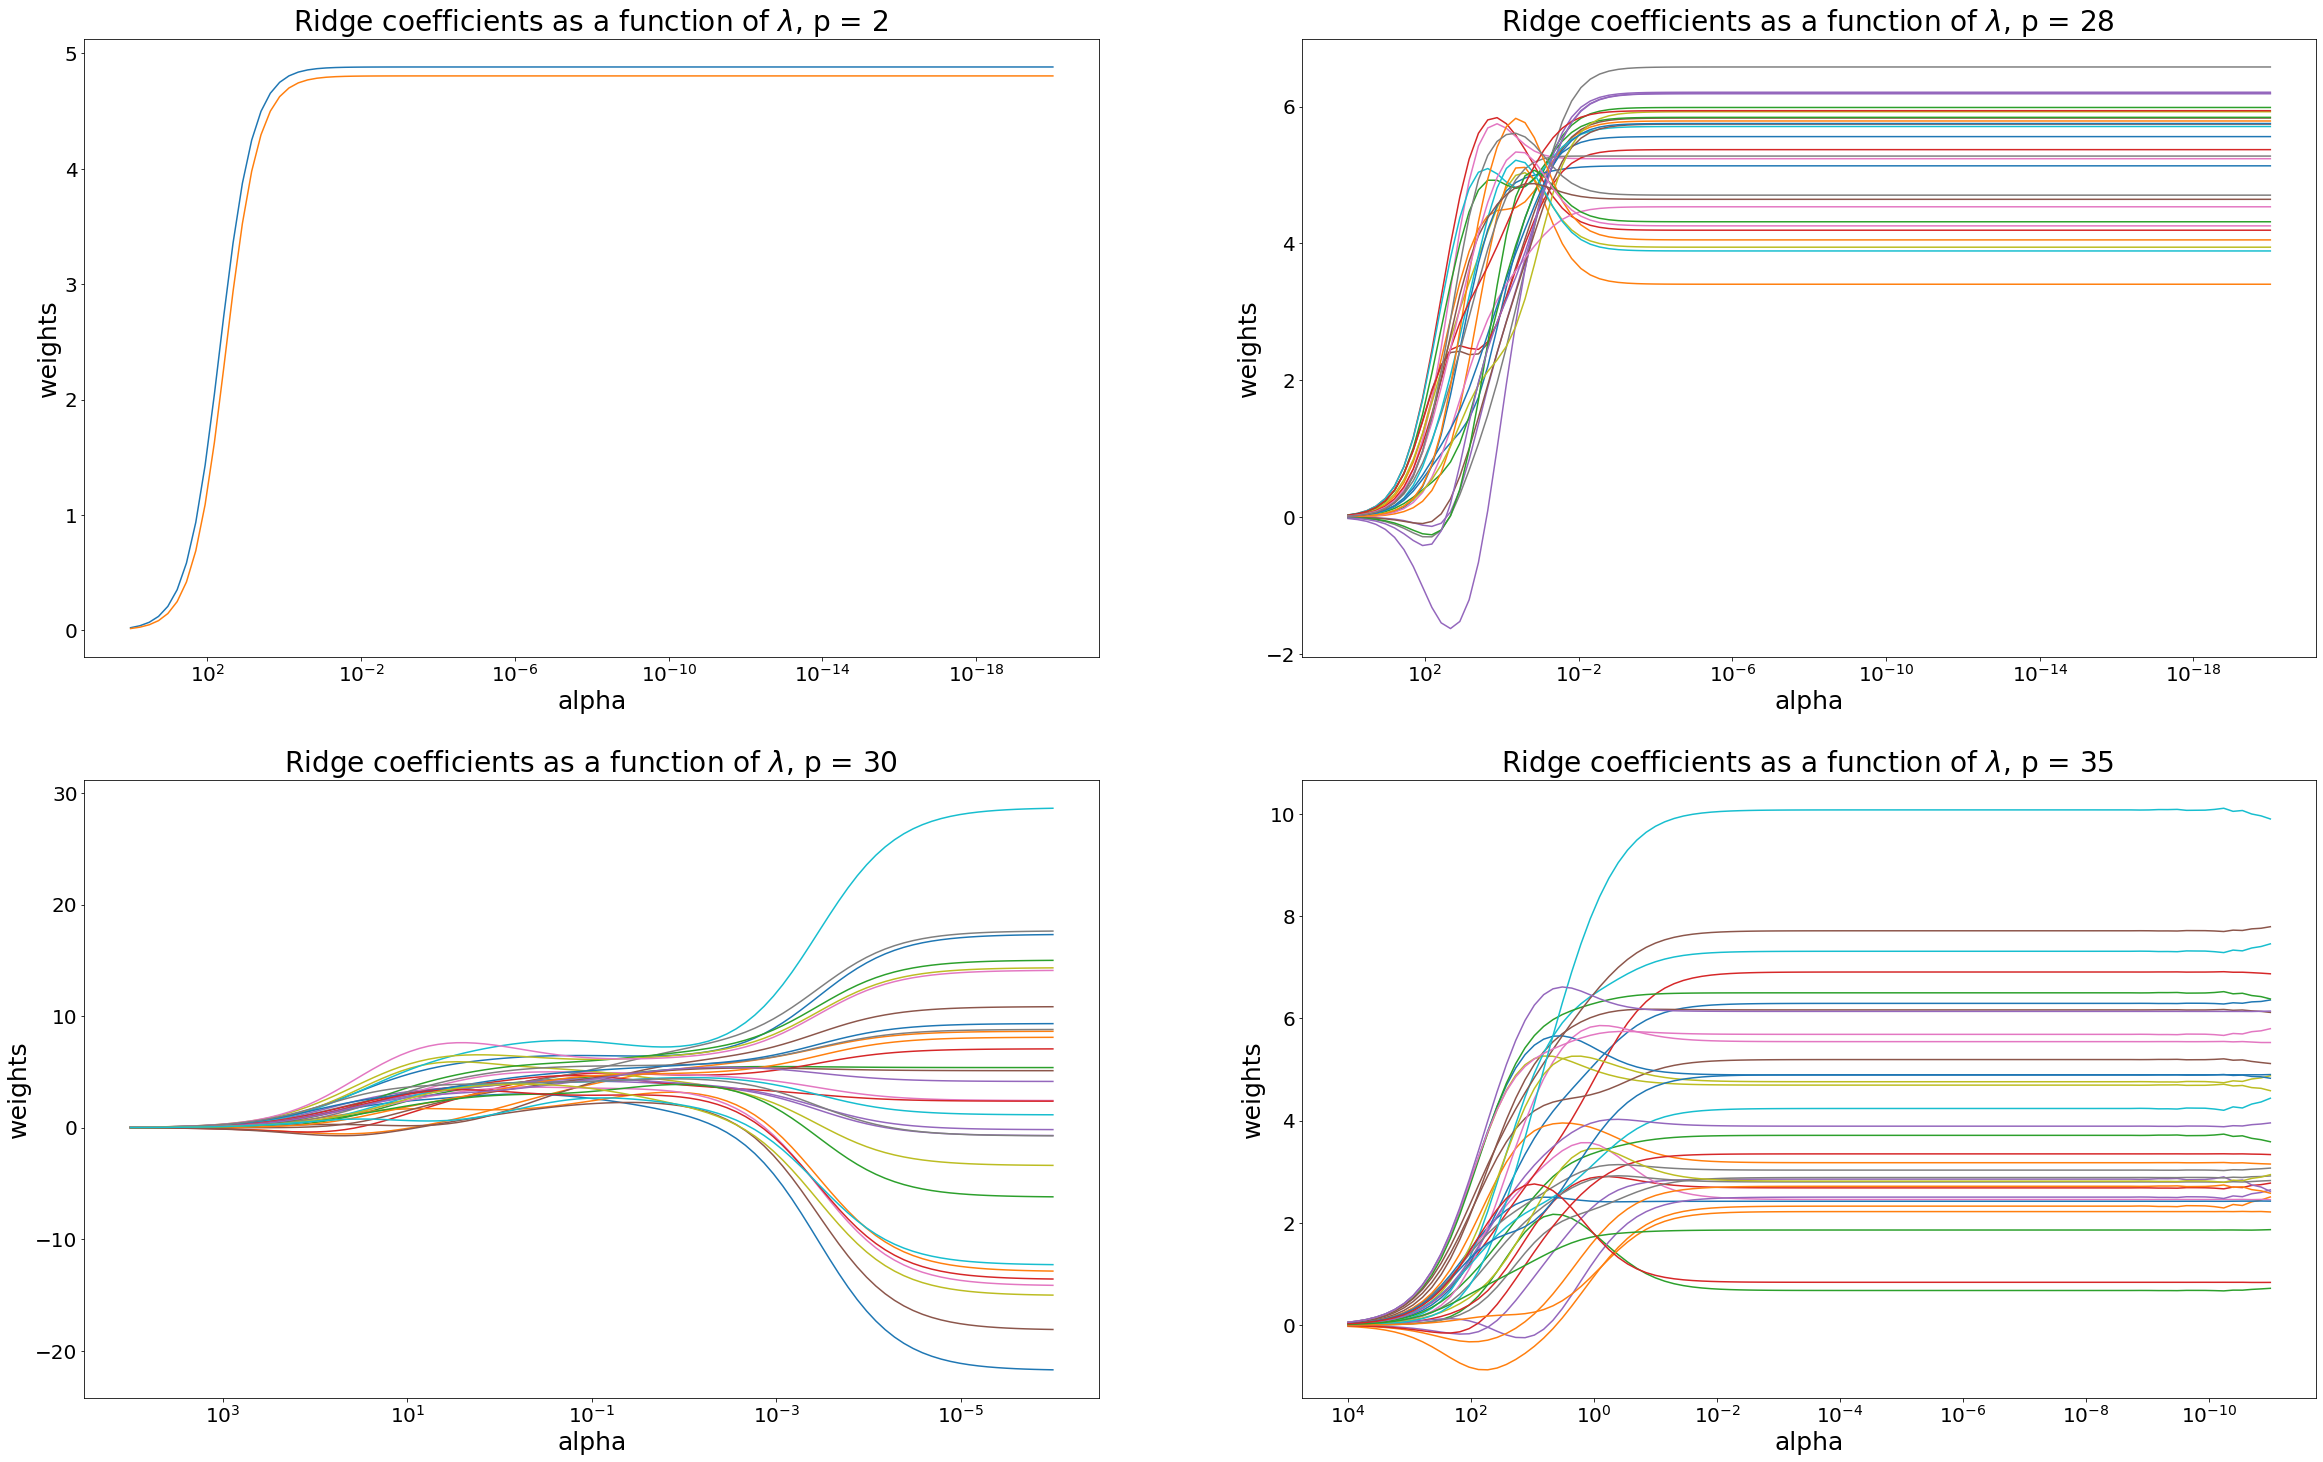

In [13]:
plot_betas(collect_ridge_betas, alphas, regularization_type)

$$
V\left(\hat{\boldsymbol{\beta}}^{*}\right)=\sigma^{2}\left[\mathbf{X}^{\prime} \mathbf{X}+k \mathbf{I}\right]^{-1}\left(\mathbf{X}^{\prime} \mathbf{X}\right)\left[\mathbf{X}^{\prime} \mathbf{X}+k \mathbf{I}\right]^{-1}.
$$

In [28]:
n = 30
min_cor = 0 
max_cor = 0 
iterations_sim = 1000

In [29]:
np.random.seed(15)

df_list_betas_ridge_2, df_list_var_ridge_2 = iterate_ridge(n, 2, min_cor, max_cor, iterations_sim, np.repeat(5, 2), alphas_3)

mean_df_list_betas_ridge_2 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_2) / iterations_sim
mean_df_list_var_ridge_2 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_2) / iterations_sim

#mean_df_list_betas_ridge_2
#mean_df_list_betas_ridge_2["alpha"] = alphas_1
#mean_df_list_betas_ridge_2.set_index("alpha", inplace = True)
#mean_df_list_betas_ridge_2

#mean_df_list_var_ridge_2
#mean_df_list_var_ridge_2["alpha"] = alphas_1
#mean_df_list_var_ridge_2.set_index("alpha", inplace = True)
#mean_df_list_var_ridge_2


    


In [30]:
np.random.seed(15)

df_list_betas_ridge_28, df_list_var_ridge_28 = iterate_ridge(n, 28, min_cor, max_cor, iterations_sim, np.repeat(5, 28), alphas_3)

mean_df_list_betas_ridge_28 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_28) / iterations_sim
mean_df_list_var_ridge_28 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_28) / iterations_sim

#mean_df_list_betas_ridge_28
#mean_df_list_betas_ridge_28["alpha"] = alphas_1
#mean_df_list_betas_ridge_28.set_index("alpha", inplace = True)
#mean_df_list_betas_ridge_28
    
#mean_df_list_var_ridge_28
#mean_df_list_var_ridge_28["alpha"] = alphas_1
#mean_df_list_var_ridge_28.set_index("alpha", inplace = True)
#mean_df_list_var_ridge_28

In [31]:
np.random.seed(15)

df_list_betas_ridge_30, df_list_var_ridge_30 = iterate_ridge(n, 30, min_cor, max_cor, iterations_sim, np.repeat(5, 30), alphas_2)

mean_df_list_betas_ridge_30 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_30) / iterations_sim
mean_df_list_var_ridge_30 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_30) / iterations_sim

#mean_df_list_betas_ridge_30
#mean_df_list_betas_ridge_30["alpha"] = alphas_1
#mean_df_list_betas_ridge_30.set_index("alpha", inplace = True)
#mean_df_list_betas_ridge_30
    
#mean_df_list_var_ridge_30
#mean_df_list_var_ridge_30["alpha"] = alphas_1
#mean_df_list_var_ridge_30.set_index("alpha", inplace = True)
#mean_df_list_var_ridge_30

In [32]:
np.random.seed(15)

df_list_betas_ridge_35, df_list_var_ridge_35 = iterate_ridge(n, 35, min_cor, max_cor, iterations_sim, np.repeat(5, 35), alphas_3)

mean_df_list_betas_ridge_35 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_35) / iterations_sim
mean_df_list_var_ridge_35 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_35) / iterations_sim

#mean_df_list_betas_ridge_35
#mean_df_list_betas_ridge_35["alpha"] = alphas_2
#mean_df_list_betas_ridge_35.set_index("alpha", inplace = True)
#mean_df_list_betas_ridge_35
    
#mean_df_list_var_ridge_35
#mean_df_list_var_ridge_35["alpha"] = alphas_2
#mean_df_list_var_ridge_35.set_index("alpha", inplace = True)
#mean_df_list_var_ridge_35

In [33]:
dfs_try = [mean_df_list_betas_ridge_2, mean_df_list_betas_ridge_28, mean_df_list_betas_ridge_30, mean_df_list_betas_ridge_35]

In [34]:
def plot_average_betas(dfs, alphas, reg_type):

    plt.figure(figsize = (40, 25))
    count = 1

    for i, a in zip(dfs, alphas):
        plt.subplot(2, 2, count)
    
        ax = plt.gca()
    
        ax.plot(a, i)
    
        ax.set_xscale("log")
        ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    
        plt.xlabel("alpha", fontsize = 25)
        plt.ylabel("weights", fontsize = 25)
    
        ax.tick_params(axis='both', which='major', labelsize = 20)
        ax.set_ylim([0, 6])

        plt.title(f"{reg_type} coefficients as a function of $\lambda$, p = {i.shape[1]} ", fontsize = 28)
        plt.axis("tight")
        count += 1
        #plt.show()

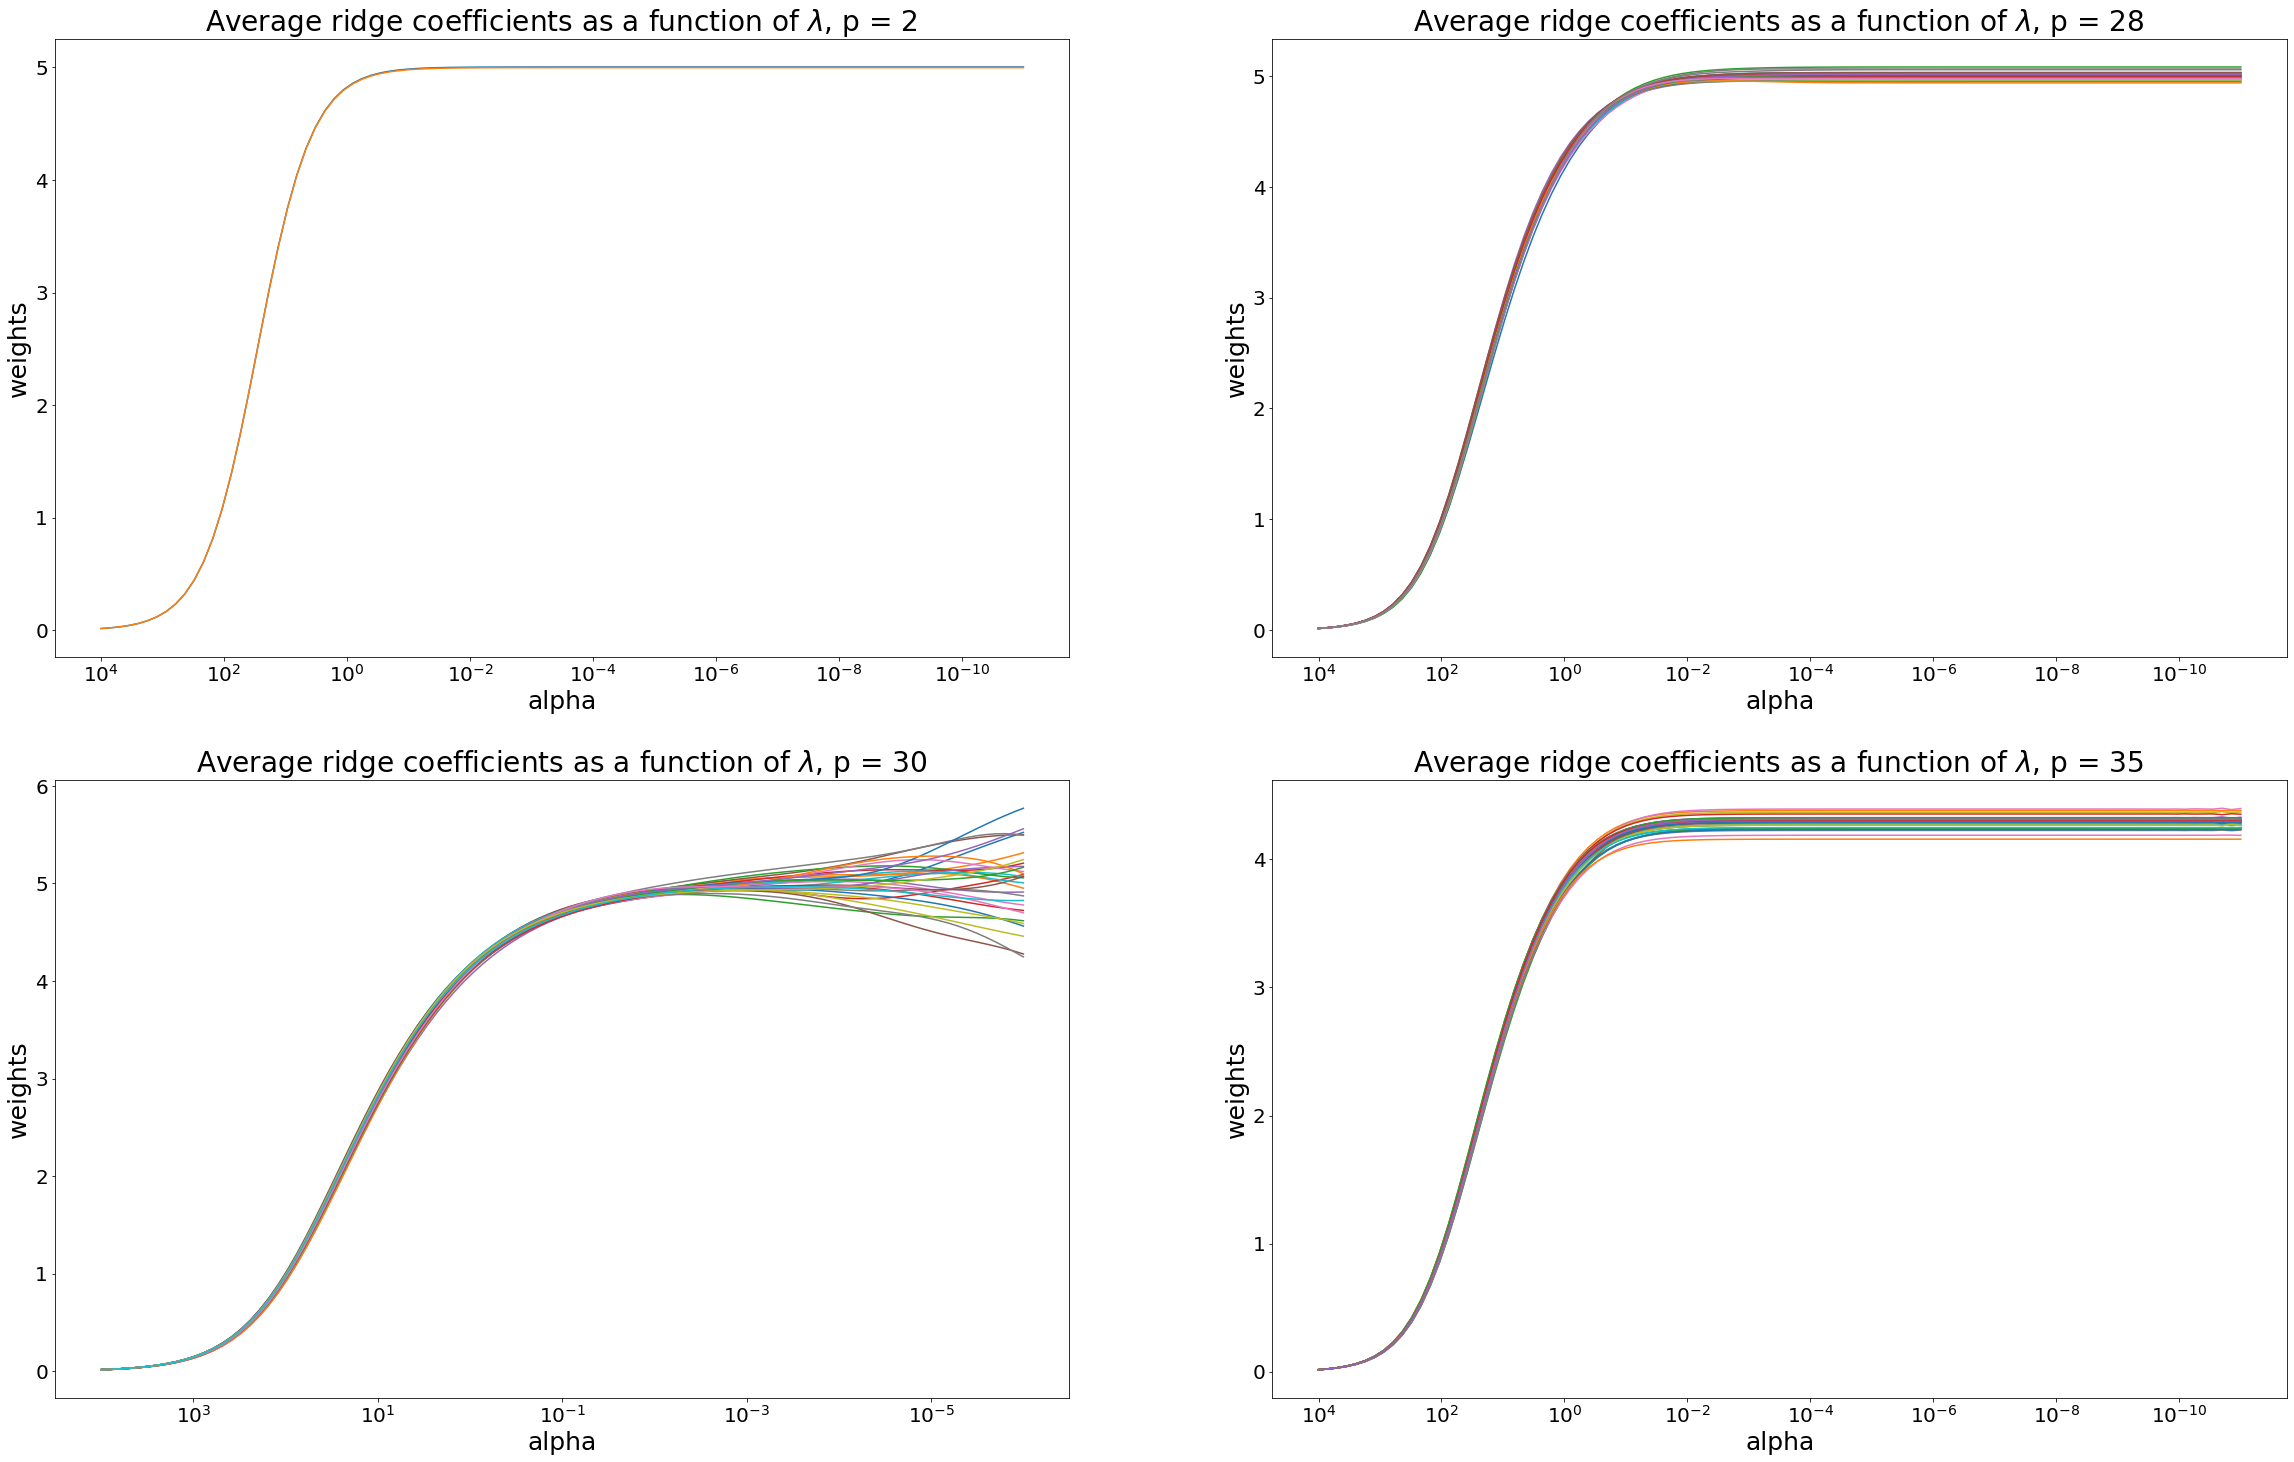

In [35]:
reg_type = "Average ridge"
alphas = [alphas_3, alphas_3, alphas_2, alphas_3]

plot_average_betas(dfs_try, alphas, reg_type)

## MSE Work 

In [36]:
np.random.seed(123)

n = 100
p = 120
min_cor = 0 
max_cor = 0 
true_betas = np.repeat(5, p)

y_true_train, y_noise_train, X_train, df_train = get_sim_data(p, n, min_cor, max_cor, true_betas)
y_true_test, y_noise_test, X_test, df_test = get_sim_data(p, n, min_cor, max_cor, true_betas)



In [37]:
"""Computed MSE manually and using mean_squared_error function from scikit learn package. Also computed variance
and bia squared. Outcomes for mse make sense in that the mse falls due to decreasing varianance and then rises
due to increased bias. But bias and variance are much larger than mse values, and mse ≠ variance + bias squared.
Variance seems to decline as is expected for increase alpha, but again is much too high. Bias squared is however decrease
instead of increasing for higher alphas."""

alphas = np.array([0, 0.00000000000000000001, 0.0000000000000000001, 0.000000000000000001, 0.00000000000000001, 0.000000000000001, 0.000000000001, 0.00000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5, 1, 2, 3, 4, 5, 6, 7, 8]) 

save_mse = []
save_mse_sci = []
save_var = []
save_var_trial = []
save_bias = []

for a in alphas: 
    ridge = Ridge(alpha=a).fit(X_train, y_true_train)
    ridge_predict = ridge.predict(X_test)

    squared_dist = (ridge_predict - y_noise_test)**2
    MSE = np.mean(squared_dist)
    save_mse.append(MSE)
    
    MSE_sci = metrics.mean_squared_error(ridge_predict, y_noise_test)
    save_mse_sci.append(MSE_sci)
    
    var_predicted_y = np.mean((np.mean(ridge_predict) - np.asarray(ridge_predict))**2)
    var_predicted_y_trial = np.sum((y_noise_test - np.mean(y_noise_test))**2) / 100


    save_var.append(var_predicted_y)
    save_var_trial.append(var_predicted_y_trial)
    
    bias_squared = np.mean((ridge_predict - np.mean(y_noise_test))**2)
    save_bias.append(bias_squared)

    



/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

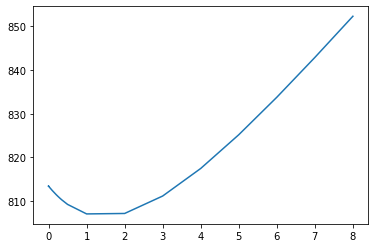

In [38]:
plt.plot(alphas, save_mse)

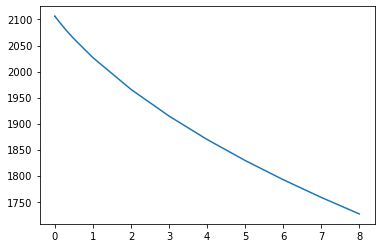

In [39]:
plt.plot(alphas, save_var)

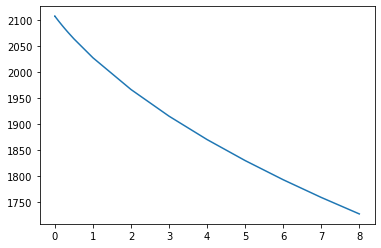

In [40]:
plt.plot(alphas, save_bias)

In [41]:
mse_trial = np.asarray(save_var_trial) + np.asarray(save_bias)

In [42]:
mse_trial

array([5294.93101817, 5294.93101817, 5294.93101817, 5294.93101817,
       5294.93101817, 5294.93101817, 5294.93101817, 5294.93101719,
       5294.93003811, 5294.92121776, 5294.83303989, 5293.95380675,
       5285.40011658, 5276.34714981, 5271.97599481, 5267.69816689,
       5263.50719392, 5251.40150021, 5214.99057163, 5153.95734756,
       5102.62884949, 5057.64151346, 5017.24348985, 4980.37370858,
       4946.32983162, 4914.61797098])

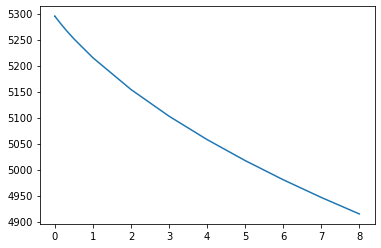

In [43]:
plt.plot(alphas, mse_trial)

In [44]:
""" Tried using bias_varinace_decomp function from package. When I do this, I get mse, bias squared, and variance values
make sense, in the sense that mse = bias squared + variance. But then, the mse computed from this function 
doesn't correspond to the mses computed manually or from the mean_squared_error function in the scikit learn 
package."""

mse = []
variance = []
bias_sq = []
mse_scik = []



for a in alphas: 

    ridge = Ridge(alpha=a)
    fit = ridge.fit(X_train, y_noise_train)
    ridge_predict = fit.predict(X_test)

    error_reg_las, bias_reg_las, var_reg_las = bias_variance_decomp(ridge, X_train.values, y_noise_train.values, X_test.values, y_noise_test.values, num_rounds = 1000, loss='mse')
    mse_scikit = metrics.mean_squared_error(y_noise_test,ridge_predict)
    #print('MSE from bias_variance lib [avg expected loss]: %.3f' % error_reg_las)
    #print('Avg Bias: %.3f' % bias_reg_las)
    #print('Avg Variance: %.3f' % var_reg_las)
    #print('Mean Square error by Sckit-learn lib: %.3f' % metrics.mean_squared_error(y_noise_test,ridge_predict))
    mse.append(error_reg_las)
    variance.append(var_reg_las)
    bias_sq.append(bias_reg_las)
    mse_scik.append(mse_scikit)


/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

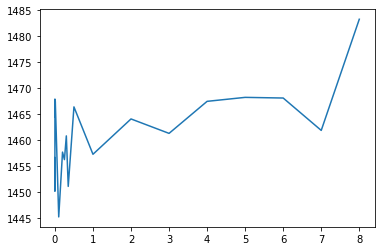

In [45]:
plt.plot(alphas, mse)

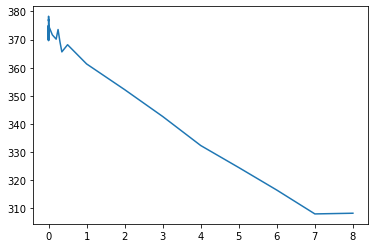

In [46]:
plt.plot(alphas, variance)

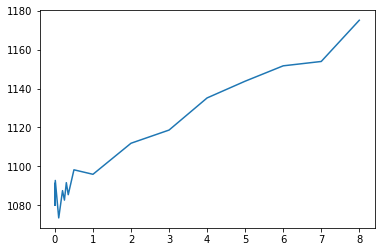

In [47]:
plt.plot(alphas, bias_sq)